# hit-song-classifier

## Random Forest Classification using Scikit-Learn

The first thing we'll do is define our imports and declare any constants.


In [1]:
# Define our imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


# Define our constants
TARGET_DATA = "../../../data/spotify_enhanced_dataset_regularized.csv"
RANDOM_SEED = 0
TARGET_FEATURES = [
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

Next, we shall split our data in a 60-20-20 train_test_val split. Then we shall build our set of inputs X. We don't want to include the features `[song, artist, year]` since they are keys. We also should define our label `class` since that is our classification feature.


In [2]:
def load_data(filename: str) -> pd.DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    return pd.read_csv(filename)


def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
    train, val = train_test_split(train, test_size=0.25, random_state=RANDOM_SEED)
    return train, val, test


def binary_class_converter(df: pd.DataFrame) -> pd.DataFrame:
    """Converts popularity to binary class

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    df["class"] = df["class"].apply(lambda x: 0 if x != 10 else 1)
    return df


def equalize_sample_size(df: pd.DataFrame) -> pd.DataFrame:
    sample_size = df["class"].value_counts().min()
    df = pd.concat(
        [
            df[df["class"] == 0].sample(sample_size, random_state=RANDOM_SEED),
            df[df["class"] == 1],
        ],
        axis=0,
    )
    return df


df = load_data(TARGET_DATA)
bin_df = binary_class_converter(df)
bin_df = equalize_sample_size(bin_df)
train_df, val_df, test_df = split_data(bin_df)
print(f"Train: {train_df.shape}\nTest: {test_df.shape}\nVal: {val_df.shape}")


Train: (3540, 18)
Test: (1181, 18)
Val: (1181, 18)


## Hyperparameter search: training multiple estimators

Here we will train multiple estimators with different hyperparameter settings. For RandomForestClassifiers, the hyperparameters we've chosen include `maxDepth` and `numTrees`.


In [3]:
def train_estimators(
    X, y, estimator_type: any, param_name: str, param_vals: list[int], **kwargs
) -> list:
    """Trains a list of estimators"""
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        estimator.fit(X, y)
        estimators.append(estimator)
        print(f"Training {estimator}")
    return estimators

In [4]:
max_depth = [1, 5, 10, 20, 50, 100]
rfc_multi = train_estimators(
    train_df[TARGET_FEATURES],
    train_df["class"],
    RandomForestClassifier,
    "max_depth",
    max_depth,
    random_state=RANDOM_SEED,
)

Training RandomForestClassifier(max_depth=1, random_state=0)
Training RandomForestClassifier(max_depth=5, random_state=0)
Training RandomForestClassifier(max_depth=10, random_state=0)
Training RandomForestClassifier(max_depth=20, random_state=0)
Training RandomForestClassifier(max_depth=50, random_state=0)
Training RandomForestClassifier(max_depth=100, random_state=0)


We want to plot estimator scores to pick the estimator with the best score.


In [5]:
def score_estimators(X, y, estimators: list) -> list:
    """Scores a list of estimators"""

    return [
        f1_score(y, estimator.predict(X), average="micro") for estimator in estimators
    ]


print(
    f"train: {score_estimators(train_df[TARGET_FEATURES], train_df['class'], rfc_multi)}"
)
print(f"val: {score_estimators(val_df[TARGET_FEATURES], val_df['class'], rfc_multi)}")
print(
    f"test: {score_estimators(test_df[TARGET_FEATURES], test_df['class'], rfc_multi)}"
)

train: [0.6819209039548022, 0.7598870056497176, 0.8692090395480226, 0.9963276836158192, 0.9988700564971752, 0.9988700564971752]
val: [0.6748518204911093, 0.7307366638441999, 0.729043183742591, 0.7332768839966131, 0.7298899237933955, 0.7298899237933955]
test: [0.663844199830652, 0.7392040643522438, 0.7400508044030483, 0.7476714648602879, 0.7400508044030483, 0.7400508044030483]


In [6]:
def plot_estimator_scores(estimators: list, param_name: str, param_vals: list[int]):
    """Plots the scores of a list of estimators"""

    train_score = score_estimators(
        train_df[TARGET_FEATURES], train_df["class"], estimators
    )
    val_score = score_estimators(val_df[TARGET_FEATURES], val_df["class"], estimators)
    test_score = score_estimators(
        test_df[TARGET_FEATURES], test_df["class"], estimators
    )

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{estimators[0].__class__.__name__} score vs. {param_name}")

    # Output scores at max_depth of the best_validation_score
    plt.text(4.7, 0.3, f"train = {train_score[best_val_idx]:.3f}", c="g", ha="right")
    plt.text(4.7, 0.2, f"validate = {best_val_score:.3f}", c="r", ha="right")
    plt.text(4.7, 0.1, f"test = {test_score[best_val_idx]:.3f}", c="k", ha="right")
    plt.legend()

CPU times: user 605 ms, sys: 12.1 ms, total: 617 ms
Wall time: 635 ms


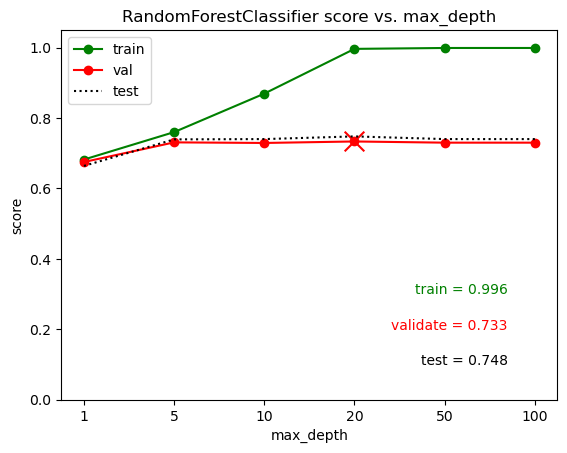

In [7]:
%%time
plot_estimator_scores(rfc_multi, "max_depth", max_depth)

In [8]:
num_trees = [1, 5, 10, 20, 50, 100]
rfc_trees = train_estimators(
    train_df[TARGET_FEATURES],
    train_df["class"],
    RandomForestClassifier,
    "n_estimators",
    num_trees,
    random_state=RANDOM_SEED,
)

Training RandomForestClassifier(n_estimators=1, random_state=0)
Training RandomForestClassifier(n_estimators=5, random_state=0)
Training RandomForestClassifier(n_estimators=10, random_state=0)
Training RandomForestClassifier(n_estimators=20, random_state=0)
Training RandomForestClassifier(n_estimators=50, random_state=0)
Training RandomForestClassifier(random_state=0)


CPU times: user 270 ms, sys: 3.84 ms, total: 274 ms
Wall time: 274 ms


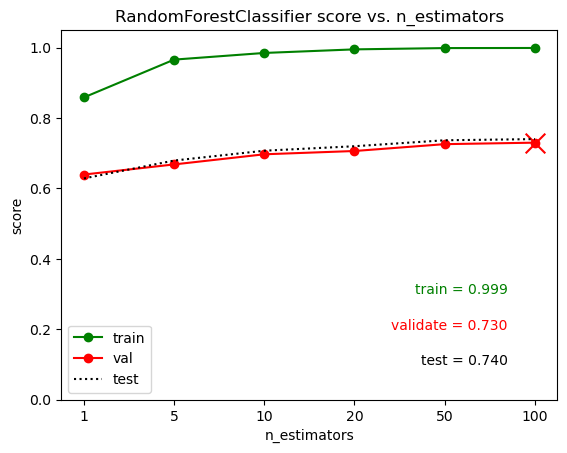

In [9]:
%%time
plot_estimator_scores(rfc_trees, "n_estimators", num_trees)

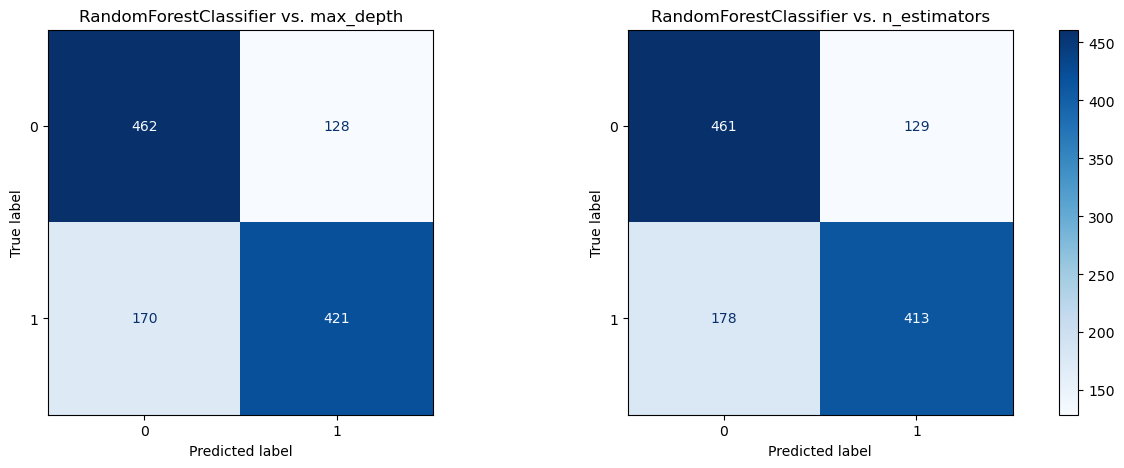

In [10]:
model_list = [rfc_multi, rfc_trees]
model_names = ["max_depth", "n_estimators"]

# Generate a confusion matrix for each best model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


def generate_confusion_matrix(
    model_list: list, val_df: pd.DataFrame, test_df: pd.DataFrame
):
    """Generates a confusion matrix for each model in model_list"""

    for i, model in enumerate(model_list):
        val_score = score_estimators(val_df[TARGET_FEATURES], val_df["class"], model)
        best_val_score = max(val_score)
        best_val_idx = val_score.index(best_val_score)

        # Generate confusion matrix
        con_mtrx = sklearn.metrics.ConfusionMatrixDisplay.from_estimator(
            model[best_val_idx],
            test_df[TARGET_FEATURES],
            test_df["class"],
            display_labels=set(test_df["class"]),
            ax=axes[i % 2],
            cmap="Blues",
            colorbar=False,
        )

        con_mtrx.ax_.set_title(f"{model[best_val_idx].__class__.__name__} vs. {model_names[i]}")

    fig.colorbar(con_mtrx.im_, ax=axes, fraction=0.046, pad=0.04)


generate_confusion_matrix(model_list, val_df, test_df)